<a href="https://colab.research.google.com/github/alekswheeler/global-_species_abundance_and_diversity/blob/main/AquecimentoGlobalEAbumdanciaDeEspecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

## Definição do problema

## Descrição do conjunto de dados

In [ ]:
pip install pygbif

Variáveis utilizadas na análise do artigo *“Estimating Extinction Risks with Species Occurrence Data from the Global Biodiversity Information Facility”* (Dasgupta, Blankespoor e Wheeler, 2024).  

As variáveis analisadas incluem:  

- **Espécies:**  
  - **species:** espécies com dados de ocorrência no GBIF.  
  - **d_assignedrisk:** indicação se a espécie está listada na Lista Vermelha da IUCN (1 para sim, 0 para não).  

- **Ameaças:** fatores que influenciam o risco de extinção, como:  
  - **parkpct:** índice de proteção formal, calculado com base na presença da espécie em áreas protegidas.  
  - **popdens:** densidade populacional, medida em um raster espacial dividido em 15 grupos.  
  - **eezpct:** percentual da área de ocorrência da espécie dentro de Zonas Econômicas Exclusivas (EEZ).  
  - **popshadow:** influência populacional costeira, baseada na projeção de dados terrestres sobre áreas marítimas.  
  - **totfishing:** intensidade total da pesca, estimada por monitoramento via satélite e sistemas AIS.  
  - **natfishing:** intensidade da pesca considerando impactos ambientais, calculada a partir de imagens de satélite.  
  - **pthreat:** índice de probabilidade de ameaça, variando de 0 a 100.  
  - **popgroupmax:** grupo máximo de densidade populacional, classificado em uma escala de 1 a 15.  

O estudo utiliza dados de diversas fontes, incluindo a IUCN, Global Fishing Watch e bases de dados espaciais, para estimar riscos de extinção com base na ocorrência das espécies.

Por conta do tamanho do conjunto de dados a importaçao é feita buscando o dado diretamente em algum serviço de armazenamento

In [7]:
import os
import zipfile
import requests

# 🔗 URL do Dropbox (modificada para permitir download direto)
dropbox_url = "https://www.dropbox.com/scl/fi/uanikg1a1jklpjyzl5j0x/global_biod_species_extinction_risks.zip?rlkey=fmb0q5n8tth1cvw9rt93a25n4&e=2&st=8iex1p7w&dl=1"

# 📂 Nome do arquivo ZIP localmente no Colab
zip_path = "dataset.zip"

# ⬇️ Baixa o arquivo ZIP do Dropbox
response = requests.get(dropbox_url)
with open(zip_path, "wb") as f:
    f.write(response.content)

print("✅ Download concluído!")

# 📂 Pasta de extração
extract_folder = "/content/dataset_csvs"
os.makedirs(extract_folder, exist_ok=True)

# 🔄 Extrai todos os arquivos CSV do ZIP
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_folder)

# 🔍 Lista os arquivos extraídos
csv_files = [f for f in os.listdir(extract_folder) if f.endswith(".csv")]

print("\n📂 Arquivos CSV extraídos:")
for file in csv_files:
    print(f"- {file}")

print("\n✅ Extração concluída! Todos os CSVs estão em:", extract_folder)


✅ Download concluído!

📂 Arquivos CSV extraídos:
- global_biod_species_extinction_risks.csv

✅ Extração concluída! Todos os CSVs estão em: /content/dataset_csvs


Como o conjunto original tem muitos dados, optamos por escolher aleatoriamente alguns dados do conjunto original para fazer a análise. Não é possível estratitificar essa escolha considerando a classe pois o conjunto original não tem essas informações apenas o ID de cada espécie.

In [8]:
import pandas as pd

SEED = 1234

df = pd.read_csv("/content/dataset_csvs/global_biod_species_extinction_risks.csv")

df = df.sample(n=500, random_state=SEED)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 15393 to 32079
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   species         500 non-null    object 
 1   parkpct         500 non-null    float64
 2   popden          466 non-null    float64
 3   eezpct          127 non-null    float64
 4   popshadow       127 non-null    float64
 5   totfishing      127 non-null    float64
 6   natfishing      124 non-null    float64
 7   popgroupmax     490 non-null    float64
 8   pthreat         500 non-null    float64
 9   d_assignedrisk  500 non-null    float64
 10  lcat            500 non-null    object 
dtypes: float64(9), object(2)
memory usage: 46.9+ KB


Adicionando as features de Class, kingdom e [IUCNRedListCategory](https://en.wikipedia.org/wiki/IUCN_Red_List#Categories) que basicamente indica qual o estado de conservaçao das espécies.

- **Extinto (EX)** – para além de qualquer dúvida razoável de que a espécie já não existe.
- **Extinto na natureza (EW)** – sobrevive apenas em cativeiro, cultivo e/ou fora da área de distribuição nativa, como presumido após inquéritos exaustivos.
- **Criticamente ameaçada (CR)** – num estado particularmente e extremamente crítico.
- **Ameaçado (EN)** – risco muito elevado de extinção na natureza, satisfaz qualquer um dos critérios A a E para a extinção em perigo.
- **Vulnerável (VU)** – cumpre um dos 5 critérios da Lista Vermelha e, por conseguinte, é considerada como estando em elevado risco de extinção não natural (causada pelo homem) sem intervenção humana adicional.
- **Quase Ameaçado (NT)** – perto de estar em perigo num futuro próximo.
- **Menor Risco (LR)** – é improvável que se torne ameaçada ou extinta num futuro próximo.
- **Dados Deficientes (DD)**
- **Não Avaliado (NE)**

In [14]:
import requests
import pandas as pd

def get_species_info(scientific_name):
    url = f"https://api.gbif.org/v1/species/match?scientificName={scientific_name}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("usageKey"), data.get("class"), data.get("kingdom")
    else:
        print(f"Erro ao buscar dados para {scientific_name}: {response.status_code}")
        return None, None, None

def get_iucn_category(usage_key):
    url = f"https://api.gbif.org/v1/species/{usage_key}/iucnRedListCategory"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("category")
    else:
        print(f"Erro ao buscar categoria IUCN para usageKey {usage_key}: {response.status_code}")
        return None

def enrich_dataframe(df):
    df["Class"] = None
    df["Kingdom"] = None
    df["IUCNRedListCategory"] = None

    for index, row in df.iterrows():
        usage_key, class_name, kingdom = get_species_info(row["species"])
        df.at[index, "Class"] = class_name
        df.at[index, "Kingdom"] = kingdom

        if usage_key:
            iucn_category = get_iucn_category(usage_key)
            df.at[index, "IUCNRedListCategory"] = iucn_category

    return df

df = enrich_dataframe(df)

Erro ao buscar categoria IUCN para usageKey 2303687: 204
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 15393 to 32079
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   species              500 non-null    object 
 1   parkpct              500 non-null    float64
 2   popden               466 non-null    float64
 3   eezpct               127 non-null    float64
 4   popshadow            127 non-null    float64
 5   totfishing           127 non-null    float64
 6   natfishing           124 non-null    float64
 7   popgroupmax          490 non-null    float64
 8   pthreat              500 non-null    float64
 9   d_assignedrisk       500 non-null    float64
 10  lcat                 500 non-null    object 
 11  Class                483 non-null    object 
 12  Kingdom              499 non-null    object 
 13  IUCNRedListCategory  498 non-null    object 
dtypes: float64(9), object(5)
memory 

Como é possível ver no gráfico abaixo muitas espécies não possuem uma categoria definida. Além disso algumas das categorias podem ser agrupadas para facilitar o agrupamento.

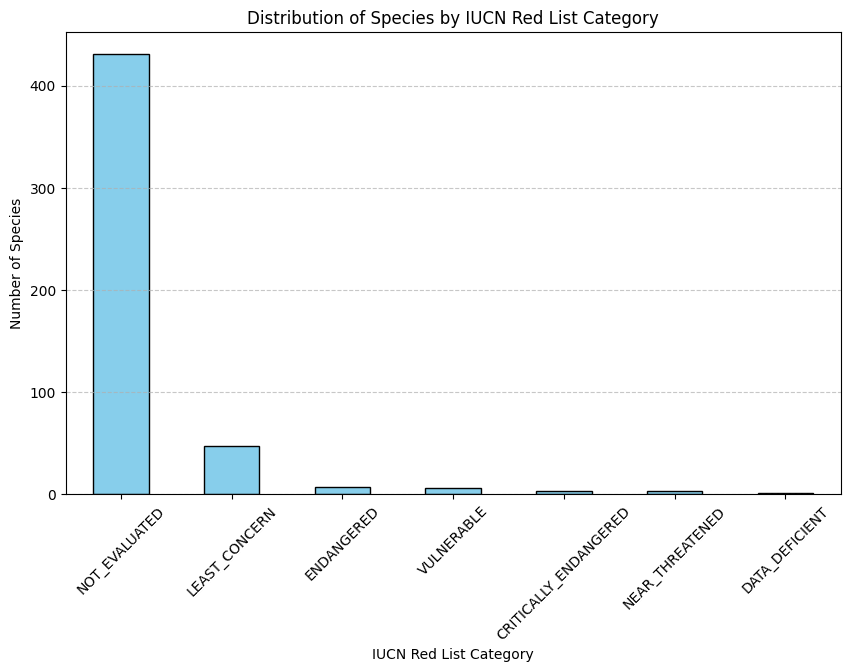

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_iucn_distribution(df):
    plt.figure(figsize=(10, 6))
    df["IUCNRedListCategory"].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel("IUCN Red List Category")
    plt.ylabel("Number of Species")
    plt.title("Distribution of Species by IUCN Red List Category")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_iucn_distribution(df)

In [11]:
# import pandas as pd
# import requests
# import time
# from pygbif import species

# # def get_class_from_api(scientific_name):
# #     url = f"https://api.gbif.org/v1/species/match?scientificName={scientific_name}"
# #     response = requests.get(url)
# #     if response.status_code == 200:
# #         data = response.json()
# #         return data.get("class", "Unknown")
# #     return "Unknown"

# def get_class_from_pygbif(scientific_name):
#     result = species.name_backbone(name=scientific_name, verbose=False, strict=True, limit=2)
#     return result.get("class", "Unknown")

# def get_extinct_status(scientific_name):
#     result = species.name_lookup(q=scientific_name, verbose=False, limit=1)
#     if "results" in result and result["results"]:
#         return 1 if result["results"][0].get("extinct", False) else 0
#     return 0

# # Adicionando a coluna 'class' com os dados da API GBIF e pygbif
# df["class"] = df["species"].apply(lambda x: get_class_from_pygbif(x))

# # Adicionando a coluna 'extinct'
# df["extinct"] = df["species"].apply(lambda x: get_extinct_status(x))

## Filtrar para tratar o problema em apenas algumas classes (e.g animalia) ??

In [21]:
# classes_visiveis = [
#     'Mammalia', 'Aves', 'Reptilia', 'Amphibia', 'Actinopterygii', 'Chondrichthyes',
#     'Insecta', 'Arachnida', 'Malacostraca'
# ]

# df_animais = df[df['species'].isin(classes_visiveis)]
# df_animais.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   species              0 non-null      object 
 1   parkpct              0 non-null      float64
 2   popden               0 non-null      float64
 3   eezpct               0 non-null      float64
 4   popshadow            0 non-null      float64
 5   totfishing           0 non-null      float64
 6   natfishing           0 non-null      float64
 7   popgroupmax          0 non-null      float64
 8   pthreat              0 non-null      float64
 9   d_assignedrisk       0 non-null      float64
 10  lcat                 0 non-null      object 
 11  Class                0 non-null      object 
 12  Kingdom              0 non-null      object 
 13  IUCNRedListCategory  0 non-null      object 
dtypes: float64(9), object(5)
memory usage: 0.0+ bytes


In [ ]:
plot_iucn_distribution(df)

# Metodologia

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

colunas_para_remover = ['species', 'lcat', 'class']  # Substitua pelos nomes reais das colunas
df_dbscan = df.drop(columns=colunas_para_remover)

# removendo NaN
# Lista das colunas numéricas com valores NaN
colunas_com_nan = ['parkpct', 'popden', 'eezpct', 'popshadow', 'totfishing',
                   'natfishing', 'popgroupmax', 'pthreat', 'd_assignedrisk']

# Preenchendo os NaN com a média da respectiva coluna
for coluna in colunas_com_nan:
    df_dbscan[coluna] = df_dbscan[coluna].fillna(df_dbscan[coluna].mean())

# --- 1️⃣ Criando o Dendrograma antes do clustering ---
# plt.figure(figsize=(8, 4))
# linked = linkage(df_dbscan[['Feature1', 'Feature2']], method='ward')
# dendrogram(linked)
# plt.title('Dendrograma Hierárquico')
# plt.xlabel('Amostras')
# plt.ylabel('Distância')
# plt.show()

# --- 2️⃣ Normalizando os dados ---
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_dbscan)

# --- 3️⃣ Aplicando DBSCAN ---
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajuste os parâmetros conforme necessário
df_dbscan['Cluster'] = dbscan.fit_predict(df_scaled)

# --- 4️⃣ Visualizando os Clusters ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_dbscan['parkpct'], y=df_dbscan['pthreat'], hue=df_dbscan['Cluster'], palette='Set1', s=50)
plt.title('DBSCAN Clustering')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# # --- 5️⃣ Identificando Outliers ---
# outliers = df[df['Cluster'] == -1]
# print("Número de outliers detectados:", len(outliers))

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering


# --- 1️⃣ Normalizando os dados ---
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_dbscan)

# --- 2️⃣ Calculando a ligação e criando o Dendrograma ---
linked = linkage(df_scaled, method='ward')  # Método Ward

plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title('Dendrograma Hierárquico')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()

# --- 3️⃣ Aplicando o Agrupamento Hierárquico Aglomerativo ---
# Defina o número de clusters desejado ou a distância de corte
n_clusters = 3  # Defina o número de clusters que você deseja

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['Cluster'] = agg_clustering.fit_predict(df_scaled)

# --- 4️⃣ Visualizando os Clusters ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_dbscan['d_assignedrisk'], y=df_dbscan['pthreat'], hue=df_dbscan['Cluster'], palette='Set1', s=50)
plt.title('Agrupamento Hierárquico Aglomerativo')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [ ]:
df_dbscan.info()

In [ ]:
# from sklearn.model_selection import StratifiedKFold, train_test_split
# # primeiro pegar uma amostra estratificada (das classes que foram selecionadas anteriormente)
# # Criando o objeto de divisão estratificada
# k = 2
# skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# # Pegando apenas um dos folds (exemplo: o primeiro)
# for train_idx, test_idx in skf.split(df, df['class']):
#     df_grupo = df.iloc[train_idx]  # Pega um grupo estratificado
#     break  # Pegamos só o primeiro grupo, então saímos do loop

# # Agora dividimos esse grupo em treino e teste (mantendo a estratificação)
# df_train, df_test = train_test_split(df_grupo, test_size=0.2, stratify=df_grupo['class'], random_state=42)

**Todo**
- ~~Adicionar região para filtrar~~
- Adicionar classe (ou reino, ou filo) ✅
- Adicionar variável Está extinto? ✅
- Encontrar dados da região, dados de clima
- Criar csv co esses dados

**Doing**
- Classificar os dados sem as classes
- Entender a distribuiçao dos dados

**Done**
- Encontrar como adicionar classe (ou reino, ou filo)


## Pré processamento

## Visualização de dados

## Classificação

# Conclusão

## Discussãocação dos Resultados

# Video


Um vídeo (de aproximadamente 5 minutos) descrevendo o trabalho e os resultados. Pretendo divulgar esse vídeo para os demais colegas da disciplina e para os professores do DI. **Os vídeos são apenas para facilitar a correção e não serão publicados!**

# Referências

https://techdocs.gbif.org/en/openapi/

https://datacatalog.worldbank.org/search/dataset/0066034/Global-Biodiversity-Data